<a href="https://colab.research.google.com/github/AndyChiquin/SongGenIA/blob/test-ltsm_red_neuronal/proyecto_Mineria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🔹 Importar librerías necesarias
import pandas as pd
import numpy as np
import itertools
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from wordcloud import WordCloud, STOPWORDS
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# 🔹 Descargar stopwords si no están disponibles
nltk.download('stopwords')
cachedStopWords = stopwords.words("spanish")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:

# 📂 Cargar el dataset (Optimizado: solo 30% de los datos)
file_path = "DATASET_LETRAS_PART1.xlsx"

# Cargar los datos asegurando que las columnas "artist" y "lyrics" existen
try:
    df = pd.read_excel(file_path, usecols=["artist", "lyrics", "title"])
except ValueError as e:
    print(f"Error al cargar el archivo: {e}")
    print("Verifica que el archivo contenga las columnas 'artist' y 'lyrics'.")
    exit()

# Tomar solo el 30% de los datos para optimizar memoria
df = df.sample(frac=0.3, random_state=42)

# 🔍 Preprocesamiento de texto
df["lyrics"] = df["lyrics"].fillna("").astype(str).str.lower().str.strip()

# Función para tokenizar letras de canciones
def song_to_token(text):
    return ' '.join(text.split()).replace('\n', '').split(' ')

df["tokens"] = df["lyrics"].apply(song_to_token)

# 📊 **Estadísticas de longitud de letras**
lyrics_list = [" ".join(tokens) for tokens in df["tokens"].tolist() if len(tokens) > 5]
lyrics_length_list = [len(x.split(' ')) for x in lyrics_list]

if lyrics_length_list:  # Asegurar que la lista no esté vacía antes de calcular estadísticas
    print("\n📊 **Estadísticas de longitud de las canciones:**")
    print(f"🔹 Longitud promedio: {round(np.mean(lyrics_length_list), 0)} palabras")
    print(f"🔹 Longitud mínima: {np.min(lyrics_length_list)} palabras")
    print(f"🔹 Longitud máxima: {np.max(lyrics_length_list)} palabras")
else:
    print("\n⚠️ No hay suficientes datos para calcular estadísticas de longitud de las canciones.")




📊 **Estadísticas de longitud de las canciones:**
🔹 Longitud promedio: 289.0 palabras
🔹 Longitud mínima: 17 palabras
🔹 Longitud máxima: 6043 palabras


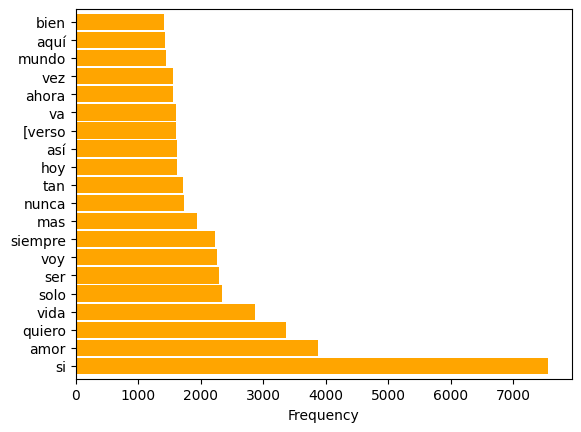

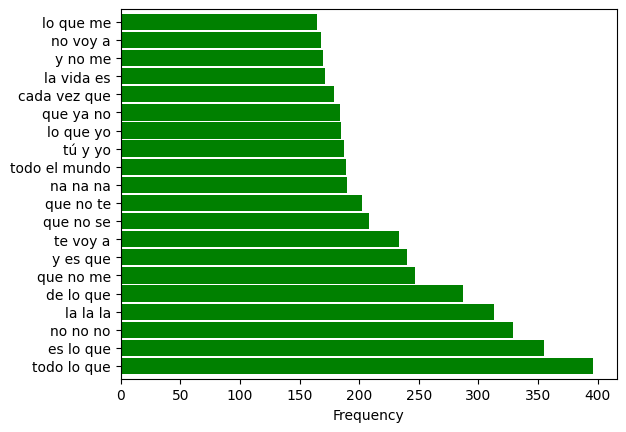

In [7]:
# 📝 **Análisis de palabras más usadas**
cachedStopWords = set(stopwords.words('spanish'))  # Cargar lista de palabras vacías en español
all_words = []

for song in lyrics_list:
    text = ' '.join([word for word in song.split() if word not in cachedStopWords])
    tokens = song_to_token(text)
    all_words.append(tokens)

all_words = list(itertools.chain.from_iterable(all_words))

# Verificar que haya palabras antes de proceder
if all_words:
    counts = pd.Series(all_words).value_counts()[:20]
    counts.plot.barh(width=0.9, color='orange')
    plt.xlabel('Frequency')
    plt.show()
else:
    print("\n⚠️ No hay suficientes palabras para generar un gráfico de frecuencias.")

# 🔍 **Análisis de bigramas/trigramas**
trigramfdist = []
special_chars = '"(),-.'

for line in lyrics_list:
    line = ''.join(c for c in line if c not in special_chars)
    tokens = song_to_token(line)
    bigrams = ngrams(tokens, 3)
    trigramfdist.append(list(bigrams))

bigramfdist = list(itertools.chain.from_iterable(trigramfdist))
concatenate_bigrams = [" ".join(x) for x in bigramfdist]

# Verificar que haya bigramas/trigramas antes de graficar
if concatenate_bigrams:
    counts = pd.Series(concatenate_bigrams).value_counts()[:20]
    counts.plot.barh(width=0.9, color='green')
    plt.xlabel('Frequency')
    plt.show()
else:
    print("\n⚠️ No hay suficientes bigramas/trigramas para generar un gráfico.")

In [8]:
print("Columnas disponibles en el DataFrame:", df.columns)

Columnas disponibles en el DataFrame: Index(['title', 'artist', 'lyrics', 'tokens'], dtype='object')


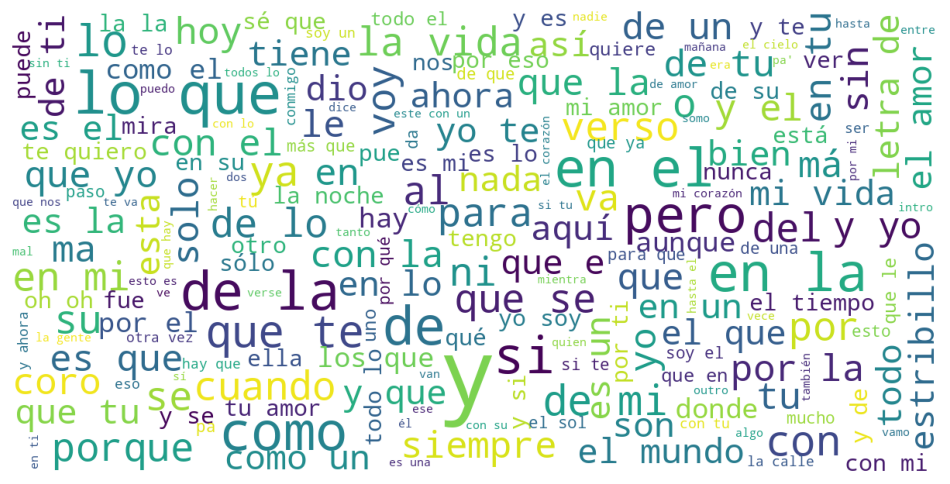


🎶 **Canciones similares con similitud coseno < 0.4:**
('A Roosevelt', 'Me acuerdo english')
('Ahora Vete', 'Vete')
('Que Tu Quieres', 'Pinocho')
('Ella', 'Sigo Con Ella')
('La Vida Es Cruel', 'La Vida Cruel')
('Arcano XIV', 'Vos Y Yo')
('Toca Viejo', 'Éxtasis', 'Libertad')
('Dame un Beso', 'Dame un beso')
('Castillo de Piedra', 'Libertad', 'Sólo Sé Que No Sé Nada', 'Éxtasis')
('Zamba Para Vos', 'Canta', 'Zamba por vos')
('Es El Amor Quien Llega', 'Bandida', 'Dos Locos De Amor', 'La soga', 'Honda Herida', 'Como Quien Pierde Una Estrella', 'Con Un Polvo Y Otro Polvo', 'Estar sin Star', 'Sin Final', 'Ay Carmela')
('Un mal paso por Tirso', 'Hala Madrid Y Nada Mas')
('Rap Yonki', 'Cuidado Con El Perro')
('La Mano de Dios', 'Rocieras del Rocío')
('Nuestra América', 'Crónica del Concierto de Edo.G en Barcelona', 'Hora 0', 'Don Quijote Primera Parte: Capítulos 8-9', 'El celoso extremeño', 'El payador perseguido', 'Lazarillo de Tormes Tratado 2', 'Guitarra Negra', 'La noche boca arriba')
('Ven

In [9]:
# ☁️ **Word Cloud**
def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(str(data))

    plt.figure(figsize=(12, 12))
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(" ".join(lyrics_list))

# 🎯 **TF-IDF (Optimizado para 5000 canciones)**
tfidf_vectorizer = TfidfVectorizer(max_features=3000, dtype=np.float32)
lyrics_sample = lyrics_list[:5000]
tfidf_X = tfidf_vectorizer.fit_transform(lyrics_sample).toarray()

# 🔍 **Cálculo de similitud coseno**
cosine_dist = squareform(pdist(tfidf_X, metric='cosine'))
similar_songs = {}

for i, song in enumerate(cosine_dist):
    res = list(set(itertools.compress(df["title"].tolist(), map(lambda x: x < 0.4, song))))
    if len(res) > 1:
        similar_songs[hash(tuple(res))] = tuple(res)

print("\n🎶 **Canciones similares con similitud coseno < 0.4:**")
for songs in similar_songs.values():
    print(songs)


In [10]:
# 🧠 **Preparación de datos**
import gc # Import the gc module
gc.collect()  # Liberar memoria
vocab_size = 5000
embedding_dim = 50
max_length = 15

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(lyrics_list)
sequences = tokenizer.texts_to_sequences(lyrics_list)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")

# **Etiquetas (One-hot encoding)**
y = np.array(padded_sequences)[:, 1:]  # Shift a la derecha para predicción
y = to_categorical(y, num_classes=vocab_size)


In [11]:
from tensorflow.keras.layers import Input # Import the Input layer
from tensorflow.keras.layers import Input, TimeDistributed # Import TimeDistributed



# 🛠️ **Definimos las dimensiones**
vocab_size = 5000
embedding_dim = 50
max_length = 15

# 📌 **Modelo LSTM con TimeDistributed**
model = Sequential([
    Input(shape=(max_length-1,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(115, return_sequences=True),
    LSTM(115, return_sequences=True),  # Se mantiene return_sequences=True
    TimeDistributed(Dense(vocab_size, activation='softmax'))
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# 🔥 **Entrenamiento del modelo**
X_train = np.array(padded_sequences)[:, :-1]
y_train = np.array(padded_sequences)[:, 1:]
y_train = to_categorical(y_train, num_classes=vocab_size)

# No es necesario aplanar y_train:
# y_train = y_train.reshape(y_train.shape[0], -1)

model.fit(X_train, y_train, epochs=800, batch_size=120, verbose=1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 14, 50)              │         250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 14, 115)             │          76,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 14, 115)             │         106,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 14, 5000)            │         580,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,012,620 (3.86 MB)

 Trainable params: 1,012,620 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.0253 - loss: 8.2619
Epoch 2/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0358 - loss: 6.6107
Epoch 3/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0383 - loss: 6.4649
Epoch 4/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0371 - loss: 6.4116
Epoch 5/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0387 - loss: 6.3827
Epoch 6/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.0386 - loss: 6.3654
Epoch 7/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0352 - loss: 6.3532
Epoch 8/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0344 - loss: 6.3511
Epoch 9/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0365 - loss: 6.3494
Epoch 10/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0371 - loss: 6.3505
Epoch 11/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0372 - loss: 6.3549
Epoch 12/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step

In [12]:


def softmax_with_temperature(probs, temperature=1.0):
    """Aplica softmax con ajuste de temperatura para diversificar la generación de palabras."""
    probs = np.asarray(probs).astype("float64")
    probs = np.log(probs + 1e-8) / temperature  # Escala probabilidades
    exp_probs = np.exp(probs)
    return exp_probs / np.sum(exp_probs)

# 🔹 Función mejorada para generar texto
def generate_song(model, tokenizer, seed_text, max_length=800, next_words=500, temperature=2.2, n_gram_penalty=2, beam_size=3):
    output_text = seed_text  # Iniciar la canción con el texto semilla
    used_ngrams = set()

    for _ in range(next_words):
        # Convertir texto a secuencia de tokens
        token_list = tokenizer.texts_to_sequences([output_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')

        # Predecir la siguiente palabra
        predicted_probs = model.predict(token_list, verbose=0)[0, -1, :]
        predicted_probs = softmax_with_temperature(predicted_probs, temperature)  # Aplicar temperatura

        # Penalización de n-gramas
        last_n_gram = tuple(int(x) for x in token_list[0][-n_gram_penalty:])  # Convertir a tupla de enteros
        for word_idx in np.argsort(predicted_probs)[-beam_size:]:  # Revisar top `beam_size` palabras
            if last_n_gram + (int(word_idx),) in used_ngrams:
                predicted_probs[word_idx] *= 0.5  # Penaliza palabras repetidas

        # Normalizar y seleccionar la palabra
        predicted_probs /= np.sum(predicted_probs)
        predicted_index = np.random.choice(len(predicted_probs), p=predicted_probs)  # Selección probabilística

        # Convertir índice a palabra
        word = tokenizer.index_word.get(int(predicted_index))

        # Si no encuentra la palabra o es un token de padding, terminar la generación
        if word is None or predicted_index == 0:
            break

        # Agregar palabra generada
        output_text += ' ' + word
        used_ngrams.add(last_n_gram + (int(predicted_index),))  # Guardar n-grama usado

    return output_text

# Generar una nueva canción con una frase inicial
seed_text = "amor de mi vida"
generated_lyrics = generate_song(model, tokenizer, seed_text, next_words=50, temperature=2.2, n_gram_penalty=2, beam_size=3)

print("\n🎶 **Nueva canción generada:**")
print(generated_lyrics)



🎶 **Nueva canción generada:**
amor de mi vida echar corre romper confío ni entonces traen rompan entonces estaba sabrás antes repetir esto el pintar beef colores entrega inmensa uh como bello low valiente disco locos pasando llegar tú ¡boom gloria vez ciudad saber todo junto en ni dime ese pendiente ahorita por mueren cobarde los cuando 20 cantar
